#**Brain Tumor Classification using CNN**

## Objective:
The goal of this project was to build a machine learning model that can classify brain MRI images into four categories: Normal, Glioma Tumor, Meningioma Tumor, and Pituitary Tumor.

## Understand the Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/drive/MyDrive/archive.zip',outdir="/content")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.9 MB/s eta 0:00:00
patool: Extracting /content/drive/MyDrive/archive.zip ...
patool: running /usr/bin/7z x -o/content -- /content/drive/MyDrive/archive.zip
patool: ... /content/drive/MyDrive/archive.zip extracted to `/content'.


'/content'

In [12]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [4]:
# Define the data directories
data_dir = '/content/Data'
normal_dir = os.path.join(data_dir, 'Normal')
glioma_dir = os.path.join(data_dir, 'Tumor/glioma_tumor')
meningioma_dir = os.path.join(data_dir, 'Tumor/meningioma_tumor')
pituitary_dir = os.path.join(data_dir, 'Tumor/pituitary_tumor')

In [5]:
# Print the number of images in each directory
print('Number of Normal images:', len(os.listdir(normal_dir)))
print('Number of Glioma images:', len(os.listdir(glioma_dir)))
print('Number of Meningioma images:', len(os.listdir(meningioma_dir)))
print('Number of Pituitary images:', len(os.listdir(pituitary_dir)))

Number of Normal images: 3066
Number of Glioma images: 6307
Number of Meningioma images: 6391
Number of Pituitary images: 5908


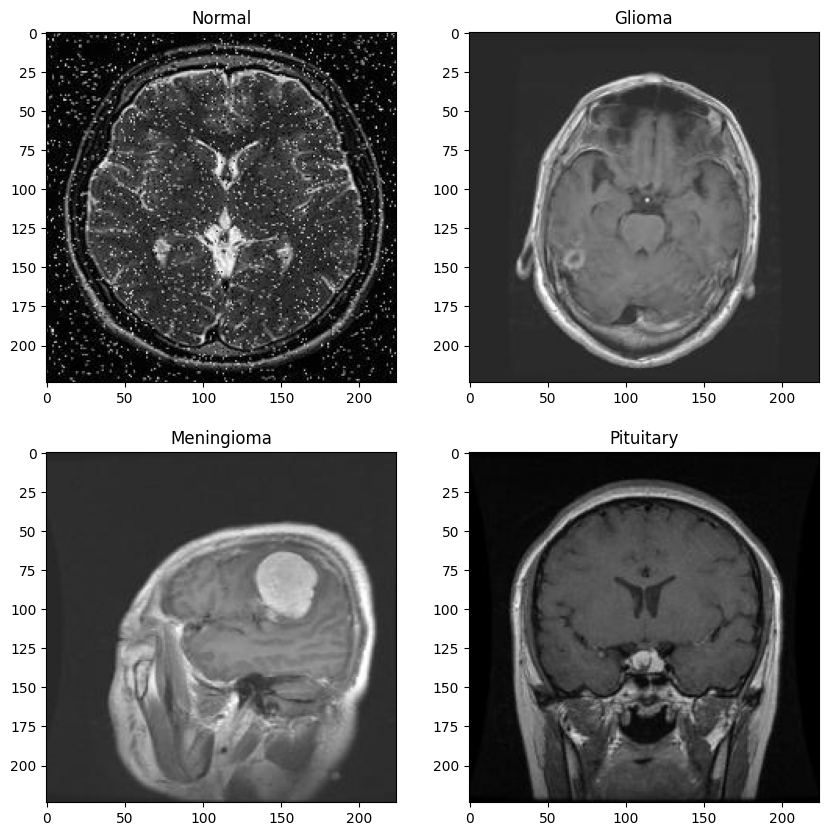

In [6]:
# Function to load and resize an image
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    return img

# Load one image from each category
normal_img = load_image(os.path.join(normal_dir, os.listdir(normal_dir)[0]))
glioma_img = load_image(os.path.join(glioma_dir, os.listdir(glioma_dir)[0]))
meningioma_img = load_image(os.path.join(meningioma_dir, os.listdir(meningioma_dir)[0]))
pituitary_img = load_image(os.path.join(pituitary_dir, os.listdir(pituitary_dir)[0]))

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(normal_img)
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(glioma_img)
plt.title('Glioma')

plt.subplot(2, 2, 3)
plt.imshow(meningioma_img)
plt.title('Meningioma')

plt.subplot(2, 2, 4)
plt.imshow(pituitary_img)
plt.title('Pituitary')
plt.show()

## Data Preprocessing and Data Augmentation

In [7]:
# Create an ImageDataGenerator object for the training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    validation_split=0.2,  # reserve some images for validation
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True  # randomly flip images
)

In [9]:
# Create a flow from the directory for the training and validation data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=['Normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'],  # explicitly specify the classes
    shuffle=True  # shuffle the data
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,  # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=['Normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'],  # explicitly specify the classes
    shuffle=True  # shuffle the data
)

Found 2453 images belonging to 4 classes.
Found 613 images belonging to 4 classes.


In [13]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))  # 4 classes
model.add(Activation('softmax'))

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 activation_2 (Activation)   (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

## Model Training

In [16]:
# Define the number of training steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Filepath to save the best model weights
    monitor='val_loss',        # Monitor the validation loss to determine the best model
    save_best_only=True,       # Save only the best model (lowest validation loss)
    save_weights_only=False    # Save the entire model (including architecture) instead of just weights
)

# Train the model with both EarlyStopping and ModelCheckpoint callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=20,
#   callbacks=[early_stopping, model_checkpoint]  # Add both callbacks to the training process
)

# Save the model after training is done
model.save('final_model.h5')

Epoch 1/20
76/76 [==============================] - 40s 527ms/step - loss: 0.0072 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
76/76 [==============================] - 39s 514ms/step - loss: 4.8855e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
76/76 [==============================] - 42s 556ms/step - loss: 1.2750e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
76/76 [==============================] - 42s 551ms/step - loss: 8.5184e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
76/76 [==============================] - 42s 548ms/step - loss: 8.9616e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
76/76 [==============================] - 41s 547ms/step - loss: 5.6975e-04 - accuracy: 0.9996 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
76/76 [==============================] - 41s 547ms/step - loss: 7.8553e-04 - accuracy: 

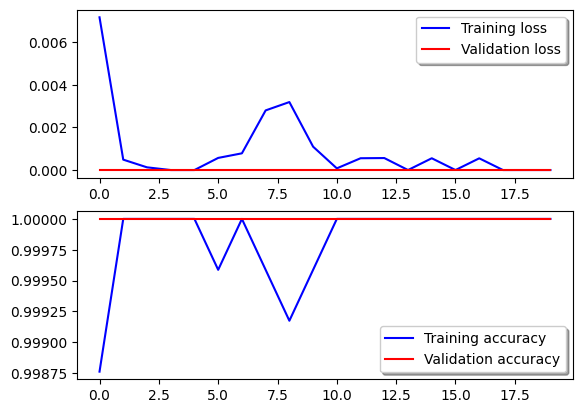

In [21]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
# Define the path to your image
image_path = '/content/Data/Normal/N_1.jpg'  # replace with your image path

# Load the image
image = cv2.imread(image_path)

# Resize the image to match the input shape for your model
image = cv2.resize(image, (224, 224))

# Normalize the image pixels
image = image / 255.0

# Expand dimensions for model prediction
image = np.expand_dims(image, axis=0)

In [23]:
# Load the trained model
model = load_model('/content/final_model.h5')

# Make a prediction
prediction = model.predict(image)

# Print the prediction
print(prediction)

1/1 [==============================] - 0s 242ms/step
[[1. 0. 0. 0.]]
